In [1]:
import os 
import torch, torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt



In [2]:
import matplotlib 
matplotlib.rcParams['figure.facecolor']='#ffffff'
project_name='sat_img_classfier'

In [3]:
data_dir = "/kaggle/input/satellite-image-classification/data"
print(os.listdir(data_dir))

['cloudy', 'desert', 'green_area', 'water']


In [4]:
## stats for Normalization
stats =((0.4914,0.4822,0.4465),(0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(64, padding=4, padding_mode='reflect'),
                        tt.RandomHorizontalFlip(),
                        tt.ToTensor(),
                        tt.Normalize(*stats, inplace=True)])

valid_tfms = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])



In [5]:
from torchvision import datasets, transforms, models


In [6]:
train_transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor()
])



test_transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor()
])



train_data = datasets.ImageFolder(data_dir, 
                                 transform=train_transforms)

test_data = datasets.ImageFolder(data_dir, transform=test_transforms)


In [7]:
batch_size = 8


In [8]:
## Time to load the data in the Dataloader
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=2, pin_memory=True)

valid_dl = DataLoader(test_data, batch_size*2, shuffle=False, num_workers =2, pin_memory=True)


In [9]:
## Lets Normalize the image tensors
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images * stds + means

In [10]:
## To display image datas from batches
def show_batch(dl):
    for images , labels in dl:
        fig , ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([])
        ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1,2,0).clamp(0,1))
        

In [11]:
# show_batch(train_dl)

In [12]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

    
def to_device(data, device):
    if isinstance(data,(list, tuple)):
        return [to_device(x, device) for x in data ]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)
    
    

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


In [15]:
class SimpleResBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,3,3,1,1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(3,3,3,1,1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = out + x 
        return out

In [16]:
simple_resnet = to_device(SimpleResBlock(), device)


In [17]:
# for images, labels in train_dl:
#     out = simple_resnet(images)
#     print(out.shape)
    

In [18]:
del simple_resnet
torch.cuda.empty_cache()

In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [20]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [21]:
model = to_device(ResNet9(3,4), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [22]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [23]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.388533592224121, 'val_acc': 0.365127831697464}]

In [24]:
epochs = 50 
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_fun = torch.optim.Adam


In [25]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_fun)

Epoch [0], last_lr: 0.00050, train_loss: 0.6468, val_loss: 0.2898, val_acc: 0.8842
Epoch [1], last_lr: 0.00081, train_loss: 0.4794, val_loss: 0.2981, val_acc: 0.8924
Epoch [2], last_lr: 0.00132, train_loss: 0.5165, val_loss: 0.3038, val_acc: 0.8967
Epoch [3], last_lr: 0.00199, train_loss: 0.4907, val_loss: 0.4899, val_acc: 0.7994
Epoch [4], last_lr: 0.00280, train_loss: 0.5338, val_loss: 0.5088, val_acc: 0.8025
Epoch [5], last_lr: 0.00372, train_loss: 0.5671, val_loss: 0.3147, val_acc: 0.9043
Epoch [6], last_lr: 0.00470, train_loss: 0.5545, val_loss: 0.2802, val_acc: 0.9117
Epoch [7], last_lr: 0.00570, train_loss: 0.4509, val_loss: 0.8369, val_acc: 0.7239
Epoch [8], last_lr: 0.00668, train_loss: 0.5044, val_loss: 0.2484, val_acc: 0.9180
Epoch [9], last_lr: 0.00760, train_loss: 0.4884, val_loss: 0.4034, val_acc: 0.8496
Epoch [10], last_lr: 0.00841, train_loss: 0.4174, val_loss: 1.4136, val_acc: 0.4492
Epoch [11], last_lr: 0.00908, train_loss: 0.3778, val_loss: 0.2249, val_acc: 0.9235
Ep

In [26]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

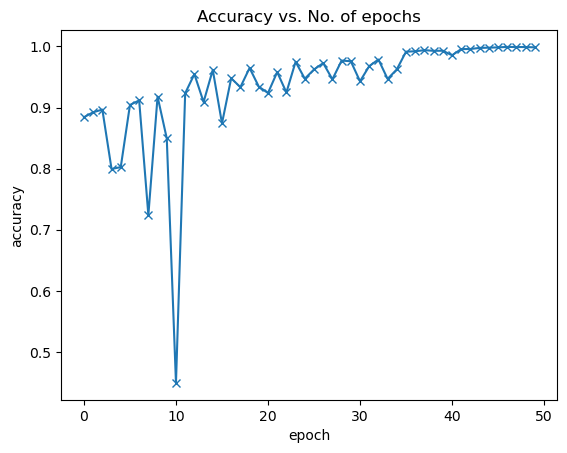

In [27]:
plot_accuracies(history)

In [28]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

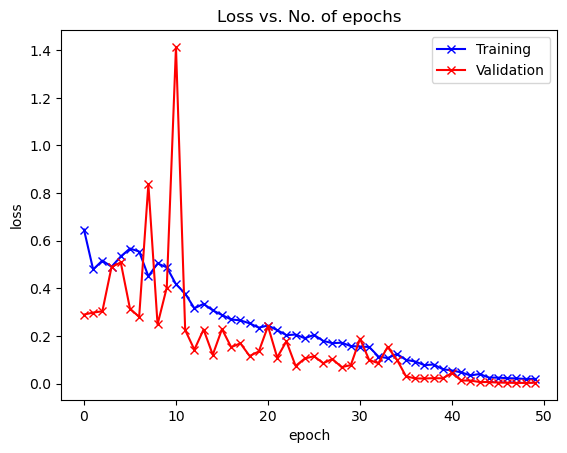

In [29]:
plot_losses(history)

In [30]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

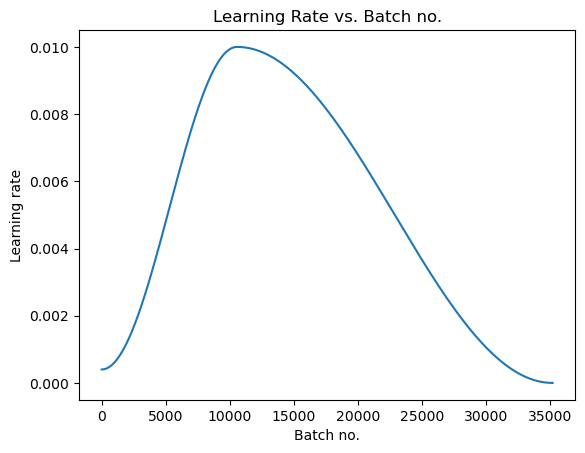

In [31]:
plot_lrs(history)

In [32]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_data.classes[preds[0].item()]

Label: cloudy , Predicted: cloudy


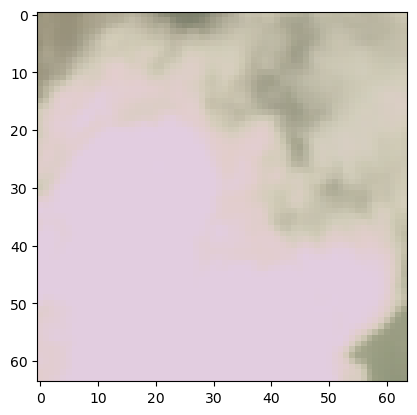

In [33]:
img, label = test_data[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_data.classes[label], ', Predicted:', predict_image(img, model))